In [1]:
import os
from options.test_options import TestOptions
from data import CreateDataLoader
from models import create_model
from util.visualizer import Visualizer
from util import html
from util.util import tensor2im
import torch
from models.cycle_gan_model import CycleGANModel
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
opt = TestOptions().parse()
opt.dataroot = 'datasets/edges2shoes/'
opt.checkpoints_dir = './checkpoints/'
opt.name = 'edges2shoes_2nd'
opt.no_dropout = False
opt.model = 'pix2pix'
opt.dataset_mode = 'aligned'
opt.loadSize = 256
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.display_id = -1  # no visdom display
opt.which_model_netG = 'unet_256'
opt.which_direction = 'AtoB'
opt.norm = 'batch'
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
model = create_model(opt)

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
dataroot: None
dataset_mode: unaligned
display_id: 1
display_port: 8097
display_server: http://localhost
display_winsize: 256
fineSize: 256
gpu_ids: [0]
how_many: 50
init_type: normal
input_nc: 3
isTrain: False
loadSize: 286
max_dataset_size: inf
model: cycle_gan
nThreads: 4
n_layers_D: 3
name: experiment_name
ndf: 64
ngf: 64
no_dropout: False
no_flip: False
norm: instance
ntest: inf
output_nc: 3
phase: test
resize_or_crop: resize_and_crop
results_dir: ./results/
serial_batches: False
suffix: 
verbose: False
which_direction: AtoB
which_epoch: latest
which_model_netD: basic
which_model_netG: resnet_9blocks
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Model : Pix2PixModel, name : G
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
-----------------------------------------------
model [Pix2PixMode

In [3]:
model.load_networks('30')

Model : Pix2PixModel, name : G


In [4]:
for i, data in enumerate(dataset):
    model.set_input(data)
    model.test()
    if i == 100:
        break
model.netG.train(False)

DataParallel(
  (module): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model.7): UnetSkipConnectionBlock(
        (model.6): UnetSkipConnectionBlock(
          (model.5): UnetSkipConnectionBlock(
            (model.4): UnetSkipConnectionBlock(
              (model.3): UnetSkipConnectionBlock(
                (model.2): UnetSkipConnectionBlock(
                  (model.1): UnetSkipConnectionBlock(
                    (_down): Sequential(
                      (0): LeakyReLU(0.2, inplace)
                      (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                    )
                    (_up): Sequential(
                      (0): ReLU(inplace)
                      (1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    )
                  )
                  

In [6]:
data_iter = iter(dataset)


In [7]:
data = next(data_iter)

In [8]:
model.set_input(data)
model.test()
visuals = model.get_current_visuals()


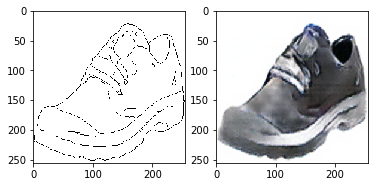

In [42]:
real_A, fake_B = map(tensor2im, [visuals['real_A'], visuals['fake_B']])
f, axarr = plt.subplots(1,2)
axarr[0].imshow(real_A)
axarr[1].imshow(fake_B)
A = model.real_A

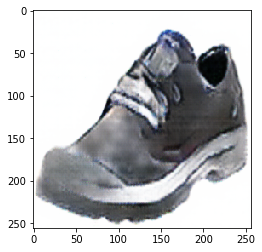

In [43]:
fake_B = model.netG(A,cache=True)
plt.imshow(tensor2im(fake_B))

In [44]:
cached_fake_B = model.netG(None, full=False)

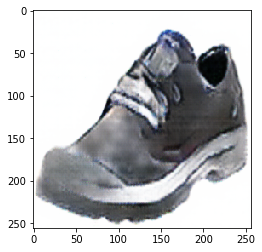

In [45]:
plt.imshow(tensor2im(cached_fake_B))

In [235]:
def intermediate(value=None):
    if value is None:
        return model.netG.module.model._submodules[-1].intermediate
    else:
        assert(value.shape == torch.Size([1,512,1,1]))
        value = value.cuda()
        model.netG.module.model._submodules[-1].intermediate = value
original_intermediate = intermediate()

In [236]:
print(f'mean : {intermediate().mean()} Max : {intermediate().max()} Min : {intermediate().min()} std : {intermediate().std()} shape : {intermediate().shape}')

mean : 0.30130717158317566 Max : 47.732582092285156 Min : 0.0 std : 3.1387054920196533 shape : torch.Size([1, 512, 1, 1])


In [247]:
intermediate(value=original_intermediate * torch.randn_like(intermediate())*10)

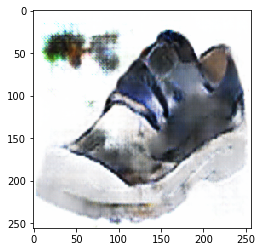

In [248]:
cached_fake_B = model.netG(None, full=False)
plt.imshow(tensor2im(cached_fake_B))